 # PtyRAD - PTYchographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

# 01. Imports

In [1]:
%reload_ext autoreload
%autoreload 2

from random import shuffle

import numpy as np
import matplotlib.pyplot as plt
import torch

GPUID = 0
DEVICE = torch.device('cuda:' + str(GPUID))
print('Execution device: ', DEVICE)
print('PyTorch version: ', torch.__version__)
print('CUDA available: ', torch.cuda.is_available())
print('CUDA version: ', torch.version.cuda)
print('CUDA device:', torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


In [2]:
from ptyrad.initialization import Initializer
from ptyrad.models import PtychoAD
from ptyrad.optimization import CombinedLoss, CombinedConstraint, ptycho_recon, loss_logger
from ptyrad.visualization import plot_forward_pass, plot_scan_positions
from ptyrad.utils import test_loss_fn, select_scan_indices, make_batches, make_recon_params_dict, make_output_folder, save_results

Importing from ptyrad


# 02. Initialize optimization

In [3]:
# from ptyrad.inputs.params_CNS import exp_params, source_params
# from ptyrad.inputs.params_PSO_128 import exp_params, source_params
# from ptyrad.inputs.params_tBL_WSe2 import exp_params, source_params

# from ptyrad.inputs.params_BaM_128 import exp_params, source_params
# from ptyrad.inputs.params_BaM_256 import exp_params, source_params
# from ptyrad.inputs.params_STO_128 import exp_params, source_params
# from ptyrad.inputs.params_NNO3_128 import exp_params, source_params
from ptyrad.inputs.params_Si_128 import exp_params, source_params


In [4]:
init = Initializer(exp_params, source_params).init_all()


### Initializing cache ###
use_cached_obj   = False
use_cached_probe = False
use_cached_pos   = False

### Initializing exp_params ###
Input values are displayed below:
kv: 300
conv_angle: 21.198
Npix: 128
rbf: None
dx_spec: 0.2249
defocus: 0
c3: 0
z_distance: 10
Nlayer: 42
N_scans: 65536
N_scan_slow: 256
N_scan_fast: 256
scan_step_size: 0.44
scan_flip: 1
scan_affine: (1, 0, -1.5, 0)
omode_max: 1
pmode_max: 5
pmode_init_pows: [0.02]
probe_permute: None
cbeds_permute: (0, 1, 3, 2)
cbeds_reshape: (65536, 128, 128)
cbeds_flip: None
probe_simu_params: None
Derived values given input exp_params:
kv          = 300 kV
wavelength  = 0.0197 Ang
conv_angle  = 21.198 mrad
Npix        = 128 px
dk          = 0.0347 Ang^-1
kMax        = 2.2232 Ang^-1
alpha_max   = 43.7694 mrad
dx          = 0.2249 Ang, Nyquist-limited dmin = 2*dx = 0.4498 Ang
Rayleigh-limited resolution  = 0.5665 Ang (0.61*lambda/alpha for focused probe )
Real space probe extent = 28.7872 Ang

### Initializing measurements from 'ma

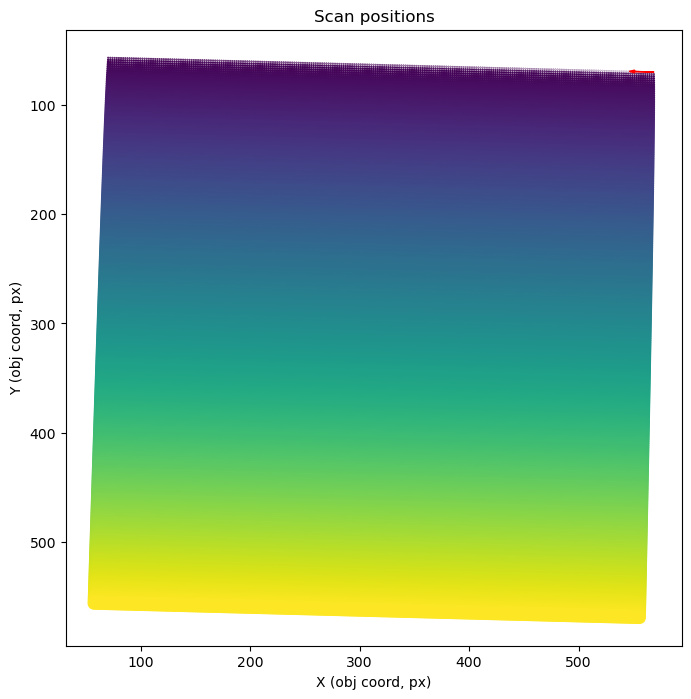

In [5]:
pos = init.init_variables['crop_pos'] + init.init_variables['probe_pos_shifts']
plot_scan_positions(pos)

In [ ]:
model_params = {
    'detector_blur_std': None,
    'lr_params':{
        'obja': 5e-4,
        'objp': 5e-4,
        'probe': 1e-3, 
        'probe_pos_shifts': 5e-4}}

model = PtychoAD(init.init_variables, model_params, device=DEVICE)

# Use model.set_optimizer(new_lr_params) to update the variable flag and optimizer_params
optimizer = torch.optim.Adam(model.optimizer_params)

In [ ]:
# # Use this to edit learning rate if needed some refinement

# model.set_optimizer(lr_params={'obja': 1e-4,
#                                'objp': 1e-4,
#                                'probe': 1e-4, 
#                                'probe_pos_shifts': 1e-2})
# optimizer=torch.optim.Adam(model.optimizer_params)

## Check the forward pass

In [ ]:
indices = np.random.randint(0,exp_params['N_scans'],2)
dp_power = 0.5

plot_forward_pass(model, indices, dp_power, init.init_variables['obj'])

## Finetune the loss params

In [ ]:
loss_params = {
    'loss_single': {'state':  True,  'weight': 1.0, 'dp_pow': 0.5},
    'loss_pacbed': {'state': False,  'weight': 1.0, 'dp_pow': 0.2},
    'loss_tv'    : {'state': False,  'weight': 1e-5},
    'loss_l1'    : {'state': False,  'weight': 0.1},
    'loss_l2'    : {'state': False,  'weight': 1.0},
    'loss_postiv': {'state': False,  'weight': 1.0}
}

indices = np.random.randint(0,exp_params['N_scans'],16)
loss_fn = CombinedLoss(loss_params, device=DEVICE)
test_loss_fn(model, indices, loss_fn)

# Setup the iteration-wise constraint params

In [ ]:
constraint_params = {
    'ortho_pmode'   : {'freq': None},
    'ortho_omode'   : {'freq': None},
    'kz_filter'     : {'freq': 1, 'beta':1, 'alpha':1, 'z_pad':None},
    'postiv'        : {'freq': 1},
    'fix_probe_int' : {'freq': 1}
}

constraint_fn = CombinedConstraint(constraint_params, device=DEVICE)

# 03. Main optimization loop

In [ ]:
NITER        = 20
INDICES_MODE = 'center'   # 'full', 'center', 'sub'
BATCH_SIZE   = 64
GROUP_MODE   = 'sparse' # 'random', 'sparse', 'compact'
SAVE_ITERS   = 5        # scalar or None

output_dir   = 'output/Si'
postfix      = '_focusProbe_noSVD'

pos          = model.crop_pos.detach().cpu().numpy()
indices      = select_scan_indices(exp_params['N_scan_slow'], exp_params['N_scan_fast'], subscan_slow=None, subscan_fast=None, mode=INDICES_MODE)
batches      = make_batches(indices, pos, BATCH_SIZE, mode=GROUP_MODE)
recon_params = make_recon_params_dict(NITER, INDICES_MODE, BATCH_SIZE, GROUP_MODE, SAVE_ITERS)
output_path  = make_output_folder(output_dir, indices, recon_params, model, constraint_params, postfix)



In [ ]:
loss_iters = []
for iter in range(1, NITER+1):
    
    shuffle(batches)
    batch_losses, iter_t = ptycho_recon(batches, model, optimizer, loss_fn, constraint_fn, iter)
    loss_iters.append((iter, loss_logger(batch_losses, iter, iter_t)))
    
    ## Saving
    if SAVE_ITERS is not None and iter % SAVE_ITERS == 0:
        save_results(output_path, model, exp_params, source_params, loss_params, constraint_params, recon_params, loss_iters, iter_t, iter, batch_losses)

In [ ]:
# Quick plot of the loss curve
plt.figure()
plt.plot(np.array(loss_iters)[:,1])
plt.show()

In [ ]:
# Comparing the initial probe intensity, CBED intensity, and optimized probe int
init_probe_int = np.sum(np.abs(init.init_variables['probe'])**2)
init_CBED_int = np.sum(np.mean(init.init_variables['measurements'], 0))
opt_probe_int = model.opt_probe.abs().pow(2).sum().detach().cpu().numpy()
print(f"{init_probe_int}, {init_CBED_int}, {opt_probe_int}")

In [ ]:
# Visualize the probe modes
init_probe = init.init_variables['probe']
opt_probe = model.opt_probe.detach().cpu().numpy()
fig, axs = plt.subplots(2, len(opt_probe), figsize=(len(opt_probe)*2.5, 6))
for i in range(len(opt_probe)):
    ax_init = axs[0, i]
    ax_init.set_title(f"Init probe {i}")
    im_init = ax_init.imshow(np.abs(init_probe[i]))
    ax_init.axis('off')
    plt.colorbar(im_init, ax=ax_init, shrink=0.6)

    ax_opt = axs[1, i]
    ax_opt.set_title(f"Opt probe {i}")
    im_opt = ax_opt.imshow(np.abs(opt_probe[i]))
    ax_opt.axis('off')
    plt.colorbar(im_opt, ax=ax_opt, shrink=0.6)

plt.tight_layout()
plt.show()